In [5]:
import numpy as np

from datasets import load_dataset, Audio, DatasetDict
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification, TrainingArguments, Trainer

import evaluate
import torch

In [3]:
# !pip install datasets transformers==4.28.0
# !pip install evaluate

In [4]:
# mounting google drive with data for runnig in google colab

# from google.colab import drive
# drive.mount('/content/drive')

## Loading dataset and splitting on train, validation and test subsets

In [171]:
data = load_dataset('audiofolder', data_dir='drive/MyDrive/data', split="train")

Resolving data files:   0%|          | 0/999 [00:00<?, ?it/s]

In [172]:
data_train_testval = data.train_test_split(test_size=0.2, stratify_by_column='label')

In [173]:
data_val_test = data_train_testval['test'].train_test_split(0.5, stratify_by_column='label')

In [174]:
data = DatasetDict({
    'train' : data_train_testval['train'],
    'val' : data_val_test['train'],
    'test' : data_val_test['test']
})

In [175]:
data

DatasetDict({
    train: Dataset({
        features: ['audio', 'label'],
        num_rows: 799
    })
    val: Dataset({
        features: ['audio', 'label'],
        num_rows: 100
    })
    test: Dataset({
        features: ['audio', 'label'],
        num_rows: 100
    })
})

In [176]:
labels = data["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [177]:
label2id

{'blues': '0',
 'classical': '1',
 'country': '2',
 'disco': '3',
 'hiphop': '4',
 'jazz': '5',
 'metal': '6',
 'pop': '7',
 'reggae': '8',
 'rock': '9'}

In [178]:
id2label

{'0': 'blues',
 '1': 'classical',
 '2': 'country',
 '3': 'disco',
 '4': 'hiphop',
 '5': 'jazz',
 '6': 'metal',
 '7': 'pop',
 '8': 'reggae',
 '9': 'rock'}

## Preprocessing data

The chosen pretrained model is Wav2Vec2.

AutoFeatureExtractor can automatically select the correct feature extractor for a given model. We are loading parameters from pretrained checkpoint.


In [179]:
PRETRAINED_MODEL = "facebook/wav2vec2-base"

In [180]:
feature_extractor = AutoFeatureExtractor.from_pretrained(PRETRAINED_MODEL, do_normalize=True, return_attention_mask=True)

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:379: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [181]:
sampling_rate = feature_extractor.sampling_rate
sampling_rate

16000

Resampling data because chosen model is pretrained on data with sampling rate 16000 and expects inputs with same rate

In [182]:
data = data.cast_column("audio", Audio(sampling_rate=sampling_rate))

In [183]:
data["train"][0]

{'audio': {'path': '/content/drive/MyDrive/data/classical/classical.00092.wav',
  'array': array([ 0.02364477,  0.05287645,  0.05001207, ..., -0.11863092,
         -0.14675134,  0.        ]),
  'sampling_rate': 16000},
 'label': 1}

Spliting data, so inputs will have smaller dimensions and there will be more instances to train model on.

Provided function map will apply feature extractor and splitting function on datasets (preprocess function)

In [184]:
(np.mean(data['train'][0]['audio']['array']))

-0.0011177017892327929

In [185]:
np.var(data['train'][0]['audio']['array'])

0.008521265380226583

In [186]:
def splitting_data(X,y):
    X = np.array(X)
    y = np.array(y)

    newX = []
    newY = []

    n = X.shape[0]

    for i in range(n):
        X_len = X[i].shape[0]
        res = X_len%5
        X_pom = X[i][:-(res)]

        pom = np.split(X_pom,5)
        for j in range(5):
            newX.append(pom[j])
            newY.append(y[i])

    return newX, newY

In [187]:
data['train'][2]['audio']['array'].shape

(485298,)

In [188]:
max_duration = 30.0


def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    audio_labels = [x for x in examples["label"]]

    new_inputs, new_labels = splitting_data(audio_arrays, audio_labels)

    inputs = feature_extractor(
        new_inputs,
        sampling_rate=feature_extractor.sampling_rate,
        max_length=int(feature_extractor.sampling_rate * max_duration),
        truncation=True,
        return_attention_mask=True,
    )

    inputs['genre'] = new_labels
    return inputs

In [189]:
data = data.map(preprocess_function, remove_columns=["audio", "label"], batched=True, batch_size=100, num_proc=1)

Map:   0%|          | 0/799 [00:00<?, ? examples/s]

<ipython-input-186-d3f82245e804>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(X)
/usr/local/lib/python3.10/dist-packages/transformers/feature_extraction_utils.py:165: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tensor = as_tensor(value)
/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/feature_extraction_wav2vec2.py:98: RuntimeWarning: Mean of empty slice.
  normed_input_values = [(x - x.mean()) / np.sqrt(x.var() + 1e-7) for x in input_values]
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: Ru

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Auto feature extractor returns input data with its attention mask

Pretrained model expects data with columns: input_values, attention_mask and label (renaming 'genre' to 'label', dropping other columns)

In [190]:
data = data.rename_column('genre', 'label')

After feature extractor has been applied, inputs have (almost) Normal distribution

In [191]:
np.mean(data['train'][0]['input_values'])

1.1336845529529714e-08

In [192]:
np.var(data['train'][0]['input_values'])

0.9999855936309174

Model trainer expects metrics -> loading and defining accuracy function 

In [83]:
accuracy = evaluate.load("accuracy")

In [84]:
def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=eval_pred.label_ids)

## Loading pretrained model and finetuning

Using class TrainingArguments to define all parameters, and class Trainer to set data on which model should be trained and data on which it should be evaluated 

In [85]:
num_labels = len(id2label)
model = AutoModelForAudioClassification.from_pretrained(PRETRAINED_MODEL, num_labels=num_labels, label2id=label2id, id2label=id2label)

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:379: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Some weights of the model checkpoint at facebook/wav2vec2-base were not used when initializing Wav2Vec2ForSequenceClassification: ['project_q.bias', 'quantizer.weight_proj.bias', 'quantizer.weight_proj.weight', 'project_hid.weight', 'project_hid.bias', 'project_q.weight', 'quantizer.codevectors']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['projector.bias', 'classifier.bias', 'projector.we

In [86]:
BATCH_SIZE = 8
EPOCHS = 10

In [87]:
training_args = TrainingArguments(
    output_dir="music-classification",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=1,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    optim="adamw_torch"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data["train"],
    eval_dataset=data["val"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.581300,1.551554,0.496000
2,0.899700,0.944066,0.712000
3,0.628000,0.814290,0.778000
4,0.602100,0.878304,0.794000
5,0.238000,0.960501,0.802000
6,0.258300,1.131305,0.786000
7,0.168900,1.094458,0.824000
8,0.111000,1.112987,0.828000
9,0.074000,1.130263,0.826000
10,0.100000,1.104078,0.836000


TrainOutput(global_step=5000, training_loss=0.540905671506375, metrics={'train_runtime': 10406.8321, 'train_samples_per_second': 3.839, 'train_steps_per_second': 0.48, 'total_flos': 2.1845979649185774e+18, 'train_loss': 0.540905671506375, 'epoch': 10.0})

## Model evaluation

In [88]:
trainer.evaluate()

{'eval_loss': 1.104077935218811,
 'eval_accuracy': 0.836,
 'eval_runtime': 71.1775,
 'eval_samples_per_second': 7.025,
 'eval_steps_per_second': 0.885,
 'epoch': 10.0}

In [89]:
preds = trainer.predict(data['test'])

trainer.predict returns tupple with prediction scores and true labels

In [103]:
scores = preds.predictions
predicted_labels = [np.argmax(x) for x in scores]
true_labels = preds.label_ids

In [96]:
scores[0]

array([-1.3159647 , -1.1852515 , -1.0542294 , -0.73355156,  7.8110166 ,
       -0.7199259 , -0.45436066, -0.37069097,  0.16783813, -0.7181513 ],
      dtype=float32)

In [98]:
true_labels[0]

4

In [134]:
from sklearn.metrics import accuracy_score, top_k_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt
import soundfile as sf
from IPython import display

Accuracy for this model doesn't seem that good, but with top 3 accuracy score we can see that score of true class is almost always in top 3 highest scores.

In [104]:
accuracy_score(true_labels, predicted_labels)

0.782

In [105]:
top_k_accuracy_score(true_labels, scores, k=3)

0.942

In [107]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)
conf_matrix

array([[39,  0,  3,  2,  0,  1,  0,  1,  1,  3],
       [ 1, 46,  0,  0,  0,  2,  0,  0,  0,  1],
       [ 3,  0, 35,  0,  0,  3,  0,  0,  0,  9],
       [ 0,  0,  0, 32,  2,  0,  0,  8,  2,  6],
       [ 0,  0,  0,  1, 37,  0,  2,  3,  6,  1],
       [ 0,  0,  0,  0,  0, 50,  0,  0,  0,  0],
       [ 0,  0,  0,  3,  0,  0, 39,  0,  0,  8],
       [ 0,  0,  3,  3,  2,  0,  0, 42,  0,  0],
       [ 6,  0,  0,  1,  5,  0,  0,  1, 37,  0],
       [ 0,  2, 11,  0,  0,  0,  0,  0,  3, 34]])

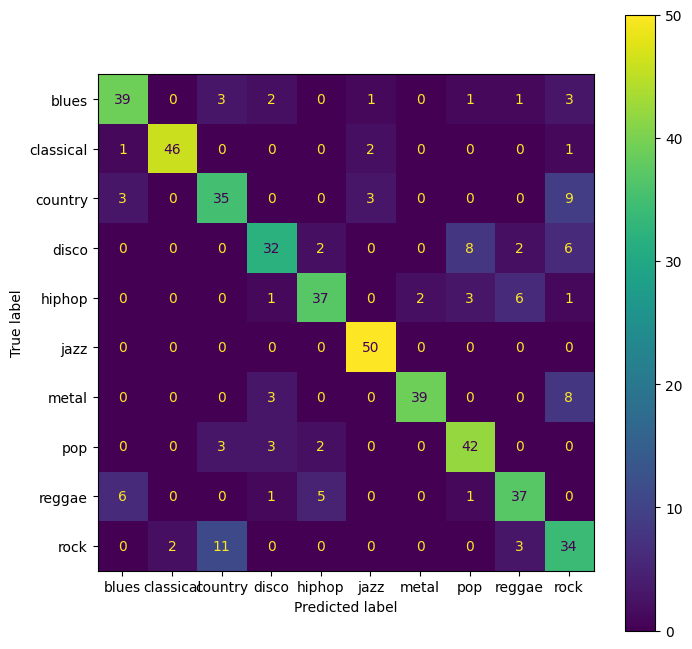

In [113]:
fig, ax = plt.subplots(figsize=(8, 8), dpi=100)
display_matrix = ConfusionMatrixDisplay(conf_matrix, display_labels = label2id.keys())
display_matrix.plot(ax=ax)

Confusion matrix has all the highest values on diagonal, so model can distinguish classes pretty well.

There are some mistakes, especially mixing classes 'rock' and 'country', but also mistaking 'metal' for 'rock' and mistaking 'disco' for 'pop'.  

## Examples of missclassified instances

In [165]:
def play_sound(x):
    sf.write("./test_sound.wav",x,16000)
    display.display(display.Audio("./test_sound.wav", rate=16000))

In [166]:
missclassified = []
for i in range(len(predicted_labels)):
    if predicted_labels[i]!= true_labels[i]:
        missclassified.append(i)

In [167]:
n = len(missclassified)
ind = [missclassified[x] for x in np.random.randint(n,size=10)]
for i in ind:
    print(f"Predicted genre: {id2label[f'{predicted_labels[i]}']}")
    print(f"True genre: {id2label[f'{true_labels[i]}']}")
    sound = np.array(data['test'][i]['input_values'])
    play_sound(sound)

Predicted genre: classical
True genre: rock


Predicted genre: country
True genre: pop


Predicted genre: rock
True genre: metal


Predicted genre: pop
True genre: hiphop


Predicted genre: rock
True genre: country


Predicted genre: rock
True genre: country


Predicted genre: rock
True genre: metal


Predicted genre: rock
True genre: disco


Predicted genre: reggae
True genre: hiphop


Predicted genre: rock
True genre: country
